In [ ]:
#Last edit: 20231014 14:35

# **Do not edit - Import essential libraries**
---

In [15]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import os
from matplotlib import gridspec
from scipy import stats

%matplotlib inline
from matplotlib import rc,rcParams
from pylab import *
# Set the ticks and label of figure

# plt.rcParams.update(matplotlib.rcParamsDefault)
params = {        
         'axes.spines.right': False,
         'axes.spines.top': False,
         'axes.spines.left': True,
         'axes.spines.bottom': True,
          
         "font.weight" : "bold",
         "axes.linewidth" : 1.5,
         "axes.labelweight" : "bold",
         "axes.titleweight" : "bold"}

plt.rcParams.update(params)

# **Do not edit - Essential functions**
---

In [7]:
def neuron_res(ext_seg, int_seg, cutoff_n):
    return 'EXT' if len(ext_seg) >= cutoff_n else 'INT' if len(int_seg) >= cutoff_n else 'NS' 

In [8]:
def bin_res(ext_seg,inh_seg,cutoff):

    if len(ext_seg) == len(inh_seg):
        res = ['EXT' if ext_seg[i]>= cutoff else 'INH' if inh_seg[i] >= cutoff else 'NR' for i in range(len(ext_seg))]
    else: 
        print('Unmatched amount between length of EXT/INH segments!')
    return np.array(res,dtype = 'str') 

In [ ]:
def star_report(p_value):
    star = ['***' if p_value < 0.001 else '**' if p_value<0.01 else '*' if p_value<0.05 else 'N.S']
    return star[0]

### Average bin heatmaps

In [123]:
def ave_heatmap(data, stimulus,state,state_type, min_criteria, col_range, chosen_stim, bar_scale , save_text, pair_cell = False ):
    #Adjusting optimal size of figure  
    f, ax = plt.subplots(nrows = 1, ncols = len(state_type),figsize=(4*len(state_type)+.5,5))
    fin_ratio =  np.array(np.repeat(4,len(state_type)),dtype = 'float')
    fin_ratio[-1] += 0.5
    spec = gridspec.GridSpec(ncols=len(state_type), nrows=1,width_ratios=fin_ratio)
    
    for i,st in enumerate(state_type):
        #Extract stimulus-associated response in given state
        norm_matrix = []
        st_indx = np.where(state == st)[0][()]
        stim_1 = stimulus[st_indx]
        norm_sig1 = data[st_indx]
        total_s = []
        for s in chosen_stim:
            total_s.append(s)
            norm_matrix.append(norm_sig1[np.where(stim_1 == s)[0][()]])
        norm_matrix = np.array(norm_matrix)

        #Classify cells based on maximum responses 
        max_indx = np.array([np.argmax(norm_matrix[:,i]) for i in range(norm_matrix.shape[1])])
        #Sort cell within class
        for j in range(len(chosen_stim)):
            pref_norm = norm_matrix[:,np.where(max_indx == j)[0][()]]
            sort_pref_norm = pref_norm[:,np.argsort(pref_norm[j,:])[::-1]]
            #Select significant units
            sort_pref_norm_res =sort_pref_norm[:,np.where(sort_pref_norm[j,:] > min_criteria)[0][()]]
            if j == 0:
                norm_sort = sort_pref_norm_res
                NR_units = sort_pref_norm[:,np.where(sort_pref_norm[j,:] <= min_criteria)[0][()]]
            else: 
                norm_sort = np.c_[norm_sort,sort_pref_norm_res]
                NR_units = np.c_[NR_units,sort_pref_norm[:,np.where(sort_pref_norm[j,:] <= min_criteria)[0][()]]]
        #Combine Non-responsive units with original heatmap 
        res_amount = norm_sort.shape[1]
        norm_sort = np.c_[norm_sort,NR_units]

        ax = plt.subplot(spec[i])#Determine plot location 
        im = ax.imshow(np.array(np.matrix.transpose(norm_sort),       
        dtype = 'float'), cmap='Blues', interpolation='none' ,vmin = col_range[0], vmax = col_range[1],aspect='auto')#plot out heatmap 
        ax.set_title(f'State: {st}')
        ax.set_ylabel(f'Cell #')
        ax.set_yticks([0,res_amount,norm_sort.shape[1]-1])
        ax.hlines(res_amount,-0.5,len(chosen_stim)-0.5, color = 'k', linestyles='dashed') #Indicate location of non-responsive neurons 
        ax.set_yticklabels([1,res_amount,norm_sort.shape[1]])
        ax.set_xticks(np.linspace(0,len(chosen_stim)-1,len(chosen_stim)))
        ax.set_xticklabels(total_s,rotation=45)
        if i+1 == len(state_type): #Only show color bar in last figure
            f.colorbar(im,label = bar_scale) 
        f.tight_layout()
        f.savefig(f'{save_text} Normalized res combined.png',dpi = 400)
        f.show()

### Response stacked bar plots

In [71]:
def response_stack_bar(fig_ratio,res,stimulus,state,stim_type,state_type,bar_width, bar_color, save_name,save = True):
    f,ax = plt.subplots(nrows = int(len(stim_type)/4), ncols = 4,figsize = fig_ratio)
    gs = gridspec.GridSpec(int(np.ceil(len(stim_type)/4)),4)
    res_filt= []
    indx = 0
    for i,comb in enumerate(itertools.product(stim_type, state_type)):
        ax = plt.subplot(gs[indx])
        res_filt.append(list(res[np.where(np.logical_and(stimulus == comb[0], state == comb[1]))]))

        if (i+1)%len(state_type) == 0 and i > 0: #All states for a given stimulus has ran through 

            t_n = np.array([len(re) for re in res_filt]) #Total cell number under different states
            bar_label = [stat+'\nn = '+str(num) for stat, num  in zip(state_type, t_n)] #State identity with corresponded cell number 
            
            #Draw stack bar plot 
            ax.bar(bar_label, ext:=100*np.array([res_filt[j].count('EXT') for j in range(len(state_type))])/t_n,\
                 bar_width, label='Excited',color =bar_color[0])
            ax.bar(bar_label,inh:=100*np.array([res_filt[j].count('INH') for j in range(len(state_type))])/t_n,\
                bar_width,bottom=ext, label='Inhibited',color =bar_color[1])
            ax.bar(bar_label, 100*np.array([res_filt[j].count('NR') for j in range(len(state_type))])/t_n,\
                 bar_width, bottom=ext+inh, label='No response',color =bar_color[2])
            ax.set_ylim(0,100)
            ax.set_ylabel('Percentage of cell (%)')
            if i == len(state_type)*len(stim_type)-1:
                ax.legend(bbox_to_anchor=(1,1), loc=2)#Show label only in the last graph 
            ax.set_title(f'{comb[0]}')
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)

            res_filt= []#Reset state 
            indx+=1 

    f.tight_layout()
    if save:
        f.savefig(f'{save_name}responsive ratio.png',dpi = 600)

# **Vglut2 + ChrimsonR**

### Data preperation

In [76]:
newpath = r"/Users/shihchelin/Desktop/Data analysis with WH/WH CPP & Chrimson"
os.chdir(newpath)#For direct preprocessing 
file_list2 = [_ for _ in os.listdir(newpath) if _.endswith('.csv')]

In [77]:
file_list2

['df Normalized signal extraction _ stats.csv',
 'z-score Normalized signal extraction _ stats.csv',
 'z-socre Normalized signal extraction _ stats.csv']

In [78]:
data = pd.read_csv(file_list2[1],header = None,low_memory = False).values

In [79]:
cell_ID=cell_ID1 = data[1,1:]
stimulus = stimulus1 = np.array(data[2,1:],dtype = 'str')
file_name = file_name1 = data[0,1:]

state = [file_name[i].split(' ')[-1] for i in range(len(file_name))]#Separate file name 
state = [state[i].split('.csv')[0] for i in range(len(state))]#Exclude ".csv"
state =  state1 = np.array([state[i].split('formalin-')[-1] for i in range(len(state))],dtype = 'str')
mice = mice1 = np.array([file_name[i].split(' ')[1] for i in range(len(file_name))],dtype = 'str')

signal =  np.array(data[19:,1:],dtype = 'float')
signal1 = signal

In [81]:
active_bin = np.array(data[8,1:],dtype = 'float')
inhibited_bin = np.array(data[9,1:],dtype = 'float')
AUC = np.array(data[6,1:],dtype = 'float')
Base_AUC = np.array(data[5,1:],dtype = 'float')
base_u = np.array(data[3,1:],dtype = 'float')
base_std = np.array(data[4,1:],dtype = 'float')

In [82]:
stim_types = np.unique(stimulus)
state_type  = np.unique(state)#Rearrange orders

#### Stim on vs stim off

In [128]:
light_state = np.array(['After' if 'post-light' in s and st == 'D1' else 'Before' if st == 'D1' else st for s,st in zip(stimulus,state)])
light_stim = np.array([s.split('post-light ')[-1] if 'post-light' in s else s for s in stimulus])

In [205]:
light_chosen_stim_R = np.unique(light_stim)[[1,3,6]]
light_chosen_stim_L = np.unique(light_stim)[[0,2,5]]
light_state_type = np.unique(light_state)[:2]

/var/folders/3w/fd_8ydn56h7dbzl8wv9lpr4c0000gn/T/ipykernel_50182/1023945741.py:76: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


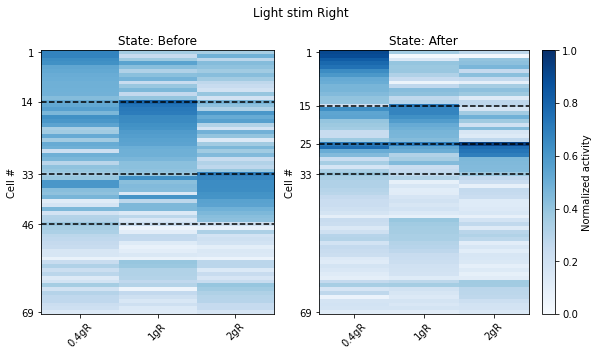

In [209]:
ave_heatmap_paired(chosen_bin, light_stim,light_state,light_state_type[::-1], 0.4 ,[0,1], light_chosen_stim_R , 'Normalized activity' , 'Light stim Right ',pair_cell = False,save_fig =True)

/var/folders/3w/fd_8ydn56h7dbzl8wv9lpr4c0000gn/T/ipykernel_50182/1023945741.py:76: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


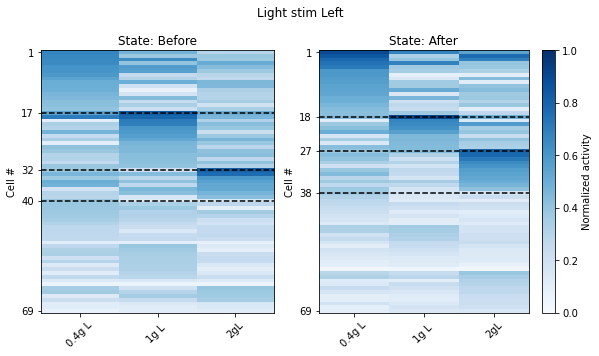

In [210]:
ave_heatmap_paired(chosen_bin, light_stim,light_state,light_state_type[::-1], 0.4 ,[0,1], light_chosen_stim_L , 'Normalized activity' , 'Light stim Left ',pair_cell = False,save_fig =True)

# **2nd batch ChrimsonR light effect**

## *Light-evoked acute responses*

In [329]:
cont_light_data = pd.read_csv(\
    r'/Users/shihchelin/Library/CloudStorage/GoogleDrive-scl0716.neuro@gmail.com/My Drive/Wei-Hsing PVT Imaging Data analysis/Raw Data/Global imaging/Chrimson stim results/Preprocessed/Extracted/Light effect only - Z-score signal extraction & stats.csv'\
        ,header = None,low_memory = False).values

In [330]:
cell_ID=cont_light_data[1,1:]
file_name = cont_light_data[0,1:]

light_signal =  np.array(cont_light_data[23:,1:],dtype = 'float')
light_time = np.array(cont_light_data[23:,0],dtype = 'float')

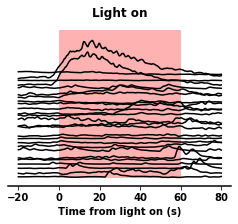

In [331]:
fig, ax = plt.subplots(figsize=(4,3))
[ax.plot(light_time, light_signal[:,i] + 10*i, '-k') for i in range(light_signal.shape[1])];
ax.fill_between([0,60], -5, 350, facecolor = 'red', alpha = .3)
ax.set(xlabel='Time from light on (s)',yticks = [], title= 'Light on')
ax.spines['left'].set_visible(False)
fig.savefig('Continuous light effect calcium traces.png', dpi = 300, bbox_inches = 'tight')

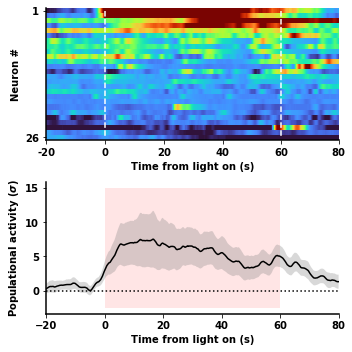

In [332]:
# norm_light_signal = light_signal - np.mean(light_signal.T[:400,:], axis = 1)
norm_light_signal=np.copy(light_signal)
sort_indx = np.argsort(np.mean(norm_light_signal[400:,:], axis = 0))
fig, ax = plt.subplots(nrows = 2,sharex = False,figsize = (5,5))
#Heatmap
im=ax[0].imshow(norm_light_signal[:,sort_indx[::-1]].T, aspect='auto', cmap = 'turbo',
          interpolation = 'none', vmax = 20, vmin = -5)
ax[0].vlines([400, 1600], 0,25, color = 'white', linestyle = 'dashed')
ax[0].set(xticks=[0,400,800,1200,1600,1990], xticklabels = [-20,0,20,40,60,80], 
       xlabel = 'Time from light on (s)', ylabel = 'Neuron #',
       yticks= [0,len(sort_indx)-1], yticklabels = [1, len(sort_indx)]);

#Plotting 
ax[1].plot(light_time, ave:=norm_light_signal.mean(axis = 1), '-', color = 'black') 
ax[1].fill_between([0,60], -2.5,15, facecolor = 'red', alpha = 0.1)
ax[1].fill_between(light_time, 
                   ave+np.std(norm_light_signal, axis = 1)/np.sqrt(len(sort_indx)),
                   ave-np.std(norm_light_signal, axis = 1)/np.sqrt(len(sort_indx)),
                   facecolor = 'grey', alpha = 0.3)
ax[1].hlines([0], -20, 80, linestyle = 'dotted', color = 'black')
ax[1].set(xlabel = 'Time from light on (s)', xlim = (-20,80), ylabel = 'Populational activity ($\sigma$)')

# cbar = fig.colorbar(im, label = 'Z-score ($\sigma$)')
fig.tight_layout()
fig.savefig('Continuous light effect heatmap + ave trace - sorted.png', dpi = 300, bbox_inches = 'tight')

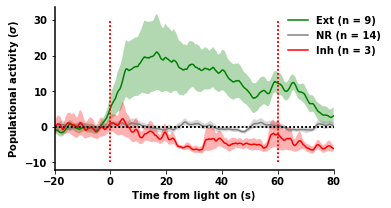

In [333]:
res_thres = 2 # ? times of difference in mean activity to define a neuron as stimulus-responsiv

light_ave_res = np.mean(norm_light_signal[400:,:], axis = 0) - np.mean(norm_light_signal[:400,:], axis = 0)
cell_class = np.array(['Ext' if n > res_thres else 'Inh' if n <-res_thres else 'NR' for n in light_ave_res])

fig,ax = plt.subplots(figsize = (5,3))
for i, re in enumerate(['Ext','NR','Inh']):
    match_indx = np.where(cell_class == re)[0]
    ave = norm_light_signal[:, match_indx].mean(axis = 1)
    shift_ave = ave - ave[:400].mean()# Vertical shifting
    shade_range = norm_light_signal[:, match_indx].std(axis = 1)/np.sqrt(len(match_indx))
    ax.plot(light_time , shift_ave,
             color = ['green','grey','red'][i], label = f'{re} (n = {len(match_indx)})')
    ax.fill_between(light_time, 
                    shift_ave+shade_range,
                    shift_ave-shade_range,
                    facecolor = ['green','grey','red'][i], alpha = .3)
    ax.vlines([0,60], -10, 30, linestyle = 'dotted', color = 'red')
    ax.hlines([0], -20, 80, linestyle = 'dotted', color = 'black')
    ax.legend(frameon = False, bbox_to_anchor=(1.2,1))
    ax.set(xlabel = 'Time from light on (s)',xlim = (-20,80), 
           ylabel = 'Populational activity ($\sigma$)')
fig.savefig('Acute light response - class-wise ave trace.png', dpi = 300, bbox_inches = 'tight')

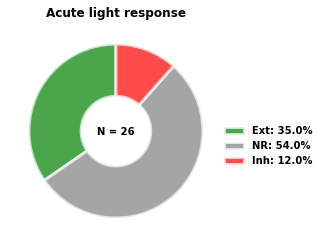

In [334]:
res_type = ['Ext','NR','Inh']
res_ratio = np.array([np.where(cell_class == re)[0].size for re in res_type])
fig, ax = plt.subplots(figsize = (4,4))
ax.pie(res_ratio  ,#labels = np.round(100*res_count/res_count.sum()), autopct='%1.1f%%',
                colors = ['green','gray','red'], 
                wedgeprops={'width':0.6,'alpha' : 0.7,'linewidth':3,'edgecolor':'w'}, 
                shadow=False, 
                startangle=90)
ax.text(0, 0, 
    f'N = {sum(res_ratio)}', 
    ha='center', va='center', fontsize=10)
ax.legend([f"{res_type[k]}: {np.round(100*res_ratio/res_ratio.sum())[k]}%" for k in range(3)],
            loc = 'lower center',frameon = False,
            ncol = 1,bbox_to_anchor = (1.2,0.3))
ax.set_title('Acute light response')
fig.savefig('Acute light response - cell response pie chart.png', dpi = 300, bbox_inches = 'tight')

## *Light effect compared to baseline*

In [335]:
data = pd.read_csv(\
    r'/Users/shihchelin/Library/CloudStorage/GoogleDrive-scl0716.neuro@gmail.com/My Drive/Wei-Hsing PVT Imaging Data analysis/Raw Data/Global imaging/Chrimson stim results/Preprocessed/Extracted/All stim - Z-score signal extraction & stats.csv'\
        ,header = None,low_memory = False).values

In [336]:
cell_ID=data[1,1:]
stimulus_all = np.array(data[2,1:],dtype = 'str')
file_name = data[0,1:]

signal =  np.array(data[21:,1:],dtype = 'float')

In [337]:
print(stim_type:=np.unique(stimulus_all))

['0.4g L' '0.4g R' '1g L ' '1g R' '2g L' '2g R' 'basal' 'during light'
 'post-light 0.4g L' 'post-light 0.4g R' 'post-light 1g L '
 'post-light 1g R' 'post-light 2g L' 'post-light 2g R' 'post-light basal']


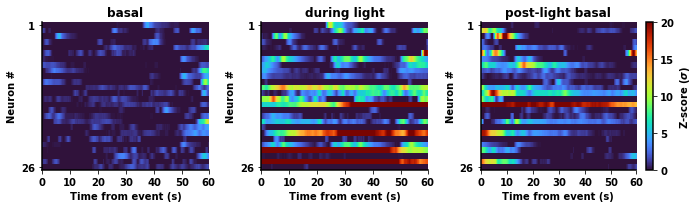

In [338]:
fig = plt.figure(figsize=(10,3))
fin_ratio =  [3,3,3.5]
spec = gridspec.GridSpec(ncols=3, nrows=1,width_ratios=fin_ratio)

for i, indx in enumerate([6,7,-1]):
    match_indx = np.where(stimulus_all == stim_type[indx])[0]
    ax = plt.subplot(spec[i])
    im = ax.imshow(signal[:,match_indx].T, aspect = 'auto', interpolation = 'none',\
                    vmin = 0, vmax = 20, cmap= 'turbo')
    ax.set(title= stim_type[indx], xticks = [0,200,400,600,800,1000,1190],
              xticklabels = [0,10,20,30,40,50,60], xlabel = 'Time from event (s)', ylabel = 'Neuron #',
              yticks= [0,len(match_indx)-1], yticklabels = [1, len(match_indx)])
cbar = fig.colorbar(im, label = 'Z-score ($\sigma$)')
fig.tight_layout()
fig.savefig('block light effect heatmap.png', dpi = 300, bbox_inches = 'tight')

In [339]:
stim_res_bins = np.array(data[12:18,1:], dtype = 'float')
max_bin = np.max(stim_res_bins, axis = 0)

comb_bin_val = []
for i, indx in enumerate([6,7,-1]):
    match_indx = np.where(stimulus_all == stim_type[indx])[0]
    comb_bin_val.append(max_bin[match_indx])
comb_bin_val = np.array(comb_bin_val)

### Classify neural response with maximum bin

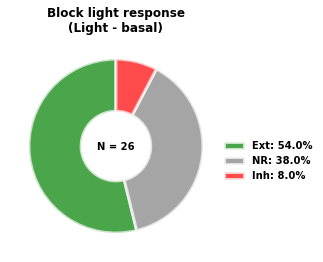

In [340]:
res_thres = 2.5 # ? times of S.D to define a neuron as stimulus-responsive 

max_bin_diff = comb_bin_val[1,:]- comb_bin_val[0,:]
cell_class = np.array(['Ext' if n > res_thres else 'Inh' if n <-res_thres else 'NR' for n in max_bin_diff])

res_type = ['Ext','NR','Inh']
res_ratio = np.array([np.where(cell_class == re)[0].size for re in res_type])

fig, ax = plt.subplots(figsize = (4,4))
ax.pie(res_ratio  ,#labels = np.round(100*res_count/res_count.sum()), autopct='%1.1f%%',
                colors = ['green','gray','red'], 
                wedgeprops={'width':0.6,'alpha' : 0.7,'linewidth':3,'edgecolor':'w'}, 
                shadow=False, 
                startangle=90)
ax.text(0, 0, 
    f'N = {sum(res_ratio)}', 
    ha='center', va='center', fontsize=10)
ax.legend([f"{res_type[k]}: {np.round(100*res_ratio/res_ratio.sum())[k]}%" for k in range(3)],
            loc = 'lower center',frameon = False,
            ncol = 1,bbox_to_anchor = (1.2,0.3))
ax.set_title('Block light response\n(Light - basal)')
fig.savefig('Block light-basal response - max bin.png', dpi = 300, bbox_inches = 'tight')

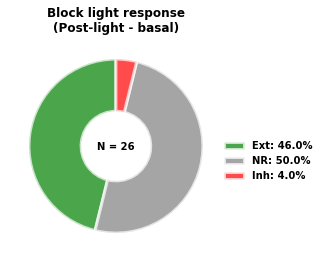

In [341]:
max_bin_diff = comb_bin_val[2,:]- comb_bin_val[0,:]
cell_class = np.array(['Ext' if n > 2.5 else 'Inh' if n <-2.5 else 'NR' for n in max_bin_diff])

res_type = ['Ext','NR','Inh']
res_ratio = np.array([np.where(cell_class == re)[0].size for re in res_type])

fig, ax = plt.subplots(figsize = (4,4))
ax.pie(res_ratio  ,#labels = np.round(100*res_count/res_count.sum()), autopct='%1.1f%%',
                colors = ['green','gray','red'], 
                wedgeprops={'width':0.6,'alpha' : 0.7,'linewidth':3,'edgecolor':'w'}, 
                shadow=False, 
                startangle=90)
ax.text(0, 0, 
    f'N = {sum(res_ratio)}', 
    ha='center', va='center', fontsize=10)
ax.legend([f"{res_type[k]}: {np.round(100*res_ratio/res_ratio.sum())[k]}%" for k in range(3)],
            loc = 'lower center',frameon = False,
            ncol = 1,bbox_to_anchor = (1.2,0.3))
ax.set_title('Block light response\n(Post-light - basal)')
fig.savefig('Block post-light-basal response - max bin.png', dpi = 300, bbox_inches = 'tight')

### Classify neural response with block average

In [342]:
comb_mean_val = []
for i, indx in enumerate([6,7,-1]):
    match_indx = np.where(stimulus_all == stim_type[indx])[0]
    comb_mean_val.append(signal[:,match_indx].mean(axis = 0))
comb_mean_val = np.array(comb_mean_val)

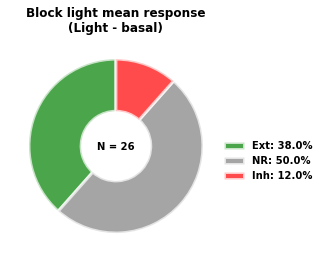

In [343]:
res_thres = 2.5 # ? times of S.D to define a neuron as stimulus-responsive 

mean_diff = comb_mean_val[1,:]- comb_mean_val[0,:]
cell_class = np.array(['Ext' if n > res_thres else 'Inh' if n <-res_thres else 'NR' for n in mean_diff])

res_type = ['Ext','NR','Inh']
res_ratio = np.array([np.where(cell_class == re)[0].size for re in res_type])

fig, ax = plt.subplots(figsize = (4,4))
ax.pie(res_ratio  ,#labels = np.round(100*res_count/res_count.sum()), autopct='%1.1f%%',
                colors = ['green','gray','red'], 
                wedgeprops={'width':0.6,'alpha' : 0.7,'linewidth':3,'edgecolor':'w'}, 
                shadow=False, 
                startangle=90)
ax.text(0, 0, 
    f'N = {sum(res_ratio)}', 
    ha='center', va='center', fontsize=10)
ax.legend([f"{res_type[k]}: {np.round(100*res_ratio/res_ratio.sum())[k]}%" for k in range(3)],
            loc = 'lower center',frameon = False,
            ncol = 1,bbox_to_anchor = (1.2,0.3))
ax.set_title('Block light mean response\n(Light - basal)')
fig.savefig('Block light-basal response - mean.png', dpi = 300, bbox_inches = 'tight')

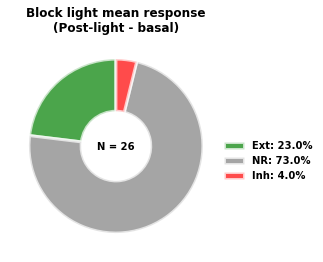

In [344]:
res_thres = 2.5 # ? times of S.D to define a neuron as stimulus-responsive 

mean_diff = comb_mean_val[2,:]- comb_mean_val[0,:]
cell_class = np.array(['Ext' if n > res_thres else 'Inh' if n <-res_thres else 'NR' for n in mean_diff])

res_type = ['Ext','NR','Inh']
res_ratio = np.array([np.where(cell_class == re)[0].size for re in res_type])

fig, ax = plt.subplots(figsize = (4,4))
ax.pie(res_ratio  ,#labels = np.round(100*res_count/res_count.sum()), autopct='%1.1f%%',
                colors = ['green','gray','red'], 
                wedgeprops={'width':0.6,'alpha' : 0.7,'linewidth':3,'edgecolor':'w'}, 
                shadow=False, 
                startangle=90)
ax.text(0, 0, 
    f'N = {sum(res_ratio)}', 
    ha='center', va='center', fontsize=10)
ax.legend([f"{res_type[k]}: {np.round(100*res_ratio/res_ratio.sum())[k]}%" for k in range(3)],
            loc = 'lower center',frameon = False,
            ncol = 1,bbox_to_anchor = (1.2,0.3))
ax.set_title('Block light mean response\n(Post-light - basal)')
fig.savefig('Block post-light-basal response - mean.png', dpi = 300, bbox_inches = 'tight')

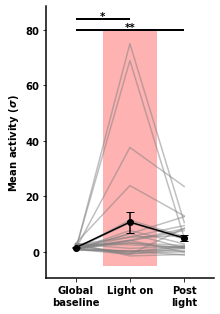

In [346]:
hline_dist = 4
hline_pos_max = 88

fig, ax = plt.subplots(figsize = (3,5))
ax.plot(comb_bin_val, color = 'gray', alpha = .5);
ax.plot(np.mean(comb_bin_val,axis = 1), '-ok')
ax.bar([0,1,2], np.mean(comb_bin_val,axis = 1), color = 'white',
        yerr= [np.std(comb_bin_val,axis = 1)/np.sqrt(comb_bin_val.shape[1])], 
        capsize=4)
ax.set(xticks = [0,1,2], ylabel = 'Mean activity ($\sigma$)')
ax.set_xticklabels(['Global\nbaseline', 'Light on', 'Post\nlight'], 
                   rotation = 0, horizontalalignment = 'center')
ax.fill_between([.5,1.5], -5,80, facecolor = 'red', alpha= .3)
stat_indx =1
for comb in itertools.combinations([0,1,2],2):
    if comb[0]!= comb[1]:
        [d_a,d_b]=[comb_bin_val[comb[0],:],comb_bin_val[comb[1],:]]
        # paired t-test
        stat_C=stats.ttest_rel(d_a, d_b,alternative='two-sided')
        if stat_C.pvalue < 0.05: 
            ax.hlines([hline_pos_max - stat_indx*hline_dist],comb[0],comb[1],color = 'black',linewidth=2) 
            ax.text(sum(comb)/2, hline_pos_max -stat_indx*hline_dist, star_report(stat_C.pvalue), horizontalalignment='center',weight="bold") 
            stat_indx+=1

fig.savefig('block light effect mean statistics.png', dpi = 300, bbox_inches = 'tight')

## **Light effect testing trial**

In [25]:
data_Ca[np.where(data_Ca[:,0] == 'Time (s)')[0][0]+1:,0] 

array(['0.0', '0.049996795077238636', '0.09999359015447727', ...,
       '779.9000064098454', '779.9500032049227', '780.0'], dtype=object)

In [38]:
calciumpath = r"/Users/shihchelin/Desktop/test/Preprocessed/Extracted"

os.chdir(calciumpath)

data_Ca = pd.read_csv("Z-score signal extraction & stats.csv",header = None, low_memory = False).values

cell_ID = data_Ca[np.where(data_Ca[:,0] == 'Cell ID')[0].min(),1:] 
file_name = data_Ca[np.where(data_Ca[:,0] == 'File name')[0],1:][0]

base_time_light = np.array(data_Ca[np.where(data_Ca[:,0] == 'Time (s)')[0][0]+1:,0],dtype = 'float')
signal_light =  np.array(data_Ca[np.where(data_Ca[:,0] == 'Time (s)')[0][0]+1:,1:],dtype = 'float')


In [13]:

def normalize(trace, dev, denominator): 
    return np.array((trace - dev)/denominator, dtype = 'float')

def standardize_extraction(signal,baseline_period= None,baseline_cutoff = 1, absolute = False):
    """
    Input
        1. signal: 1D Array of calcium trace
        2. baseline_period: A two-element vector with index of the start/end points of baseline period, default set as None (All signal considered as baseline)
        3. baseline_cutoff: ratio from 0 to 1, determine the range of signals included as baseline range (data points below the assigned cutoff after normalized would be extracted, concatenated to a continuous baseline signal session)
        4. absolute: Requirement for adjusting baseline_cutoff based on the min/max of input signal  
    Output
        1. Whole signal transformed into Z-score 
        2. baseline_sig: Partial signal from original trace with value below cutoff, defined as baseline period 
        3. ave: Average value of baseline period 
        4. sd: Standard deviation of baseline period 
    """
    baseline_sig = signal
    cutoff = baseline_cutoff if absolute else (np.max(signal)- np.min(signal))*baseline_cutoff + np.min(signal)

    if not baseline_period == None:#Baseline period defined 
        baseline_sig = signal[baseline_period[0]:baseline_period[1]]
        ave, sd = baseline_sig.mean(), np.std(baseline_sig)
    else:
        baseline_sig = signal[np.where(signal < cutoff)[0][()]]
        ave, sd = baseline_sig.mean(), np.std(baseline_sig)

    return normalize(signal, ave, sd), baseline_sig, ave, sd 
def start_end_index(time, start, pre,post, decimal = 0):
    return [np.where(np.floor(time*(10**decimal))/10**decimal == np.floor(start-pre))[0].min(),\
         np.where(np.floor(time*(10**decimal))/10**decimal == np.floor(start+post-1))[0].max()]


[ 0 31  4]


/var/folders/3w/fd_8ydn56h7dbzl8wv9lpr4c0000gn/T/ipykernel_15414/1879089804.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


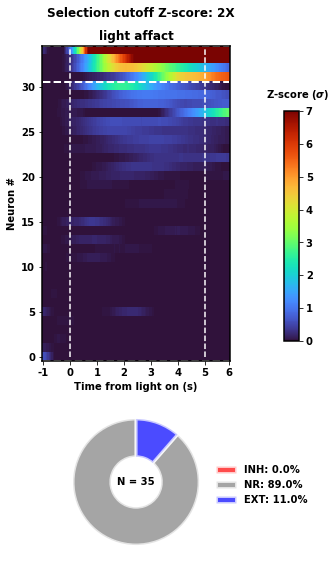

In [75]:
#Create common time scale, stay unchanged after initial definition 
selection_cutoff = 2
stim_timing = np.arange(180,601,30)
extr_range = start_end_index(base_time_light, 0,0,7)
com_t = base_time_light[extr_range[0]:extr_range[1]]-1 #Universal time

# plt.figure(figsize = (10,15))
f= plt.figure(figsize = (4,8))
spec = gridspec.GridSpec(ncols=1, nrows=2, height_ratios=[2,1])

ave_diff = []
ave_trace = []
for ci in range(signal_light.shape[1]):
    trace = signal_light[:,ci]#ok
    light_time_indx = [start_end_index(base_time_light,t,1,6) for t in stim_timing]#ok
    light_trace = np.array([standardize_extraction(trace,tt,1)[1] for tt in light_time_indx])#ok
    light_trace_dff = np.array([(light_trace[k,:] - light_trace[k,:20].mean()) for k in range(light_trace.shape[0])]).mean(axis = 0)
    # stat_power  = neurons activity 
    ave_trace.append(light_trace_dff)#.mean(axis = 0))
    ave_diff.append(np.mean(light_trace_dff[20:])- np.mean(light_trace_dff[:20]))

mean_res = np.array(['ex' if d>=selection_cutoff else 'inh' if d <=-selection_cutoff else 'nr' for d in ave_diff])

r_type = ['ex','nr','inh']
res_count = np.array([np.where(mean_res == r)[0].size for r in r_type ])[::-1]
print(res_count)
sort_indx = np.argsort(ave_diff)# if i == 0 else sort_indx][0]

ax = plt.subplot(spec[0])
im = ax.imshow(np.array(ave_trace)[sort_indx,:], cmap='turbo', 
               interpolation='none',aspect='auto',vmin = 0, vmax = 7)#Plot out heatmap 
ax.set(title = 'light affact',
            xlabel = 'Time from light on (s)',
            ylabel = 'Neuron #',
            ylim= (-.5,len(sort_indx)-.5),
            xticks = [0,20,40,60,80,100,120,138],
            xticklabels = [-1,0,1,2,3,4,5,6])
ax.vlines([20,120],0,signal_light.shape[1]-.5, color = 'white', linestyles = 'dashed')
cum_sum = np.array([res_count.sum(),res_count[:2].sum(),res_count[0]])
ax.hlines(cum_sum -.5, 0, 138, linestyles = 'dashed', color = 'white',linewidth = 2)

#Pei chart
axes = plt.subplot(spec[1])
axes.pie(res_count  ,#labels = np.round(100*res_count/res_count.sum()), autopct='%1.1f%%',
                colors = ['red','gray','blue'], 
                wedgeprops={'width':0.6,'alpha' : 0.7,'linewidth':3,'edgecolor':'w'}, 
                shadow=False, 
                startangle=90)
axes.text(0, 0, 
    f'N = {len(mean_res)}', 
    ha='center', va='center', fontsize=10)
axes.legend([f"{['INH','NR','EXT'][k]}: {np.round(100*res_count/res_count.sum())[k]}%" for k in range(3)],
            loc = 'lower center',frameon = False,
            ncol = 1,bbox_to_anchor = (1.3,.3))
ax.spines['right'].set_visible(True)
ax.spines['top'].set_visible(True)
# os.chdir('/Users/shihchelin/Desktop')
f.suptitle(f'Selection cutoff Z-score: {selection_cutoff}X',weight = 'bold')
#Add color bar
cax = f.add_axes([1, 0.4, 0.05, 0.4])
cbar = f.colorbar(im,cax = cax)
cbar.set_label('Z-score ($\sigma$)', labelpad=-15,y=1.1,rotation=360)
f.tight_layout()
# os.chdir('/Users/shihchelin/Desktop')
f.savefig('ChrimsonR Light effect - cell response summary.png', dpi = 600, bbox_inches  = 'tight')

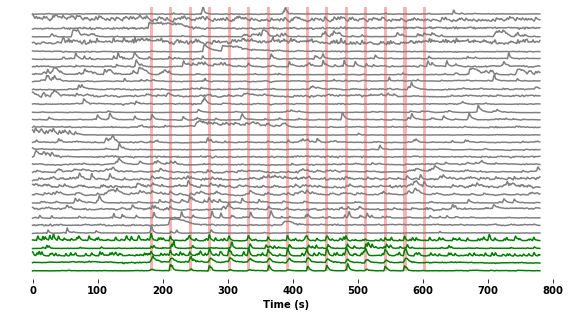

In [76]:
#Create common time scale, stay unchanged after initial definition 
selection_cutoff = 2
# sham_timing = np.arange(20,590,20)
extr_range = start_end_index(base_time_light, 0,0,7)
#Normalizing signals 
norm_sig = signal_light.copy()
for i in range(signal_light.shape[1]):
    s_min, s_max = norm_sig[:,i].min(), norm_sig[:,i].max()
    norm_sig[:,i] = normalize(norm_sig[:,i], s_min, s_max-s_min)

com_t = base_time_light[extr_range[0]:extr_range[1]]-1 #Universal time
f, ax = plt.subplots(ncols = 1, nrows = 1,figsize = (10,5))
[ax.plot(base_time_light, norm_sig[:,c]+1*j, color =  ['green' if\
 j <= res_count[-1] else 'gray' if j<= res_count[1:].sum() else 'blue'][0]) for j,c in enumerate(sort_indx[::-1])];
[ax.fill_between([t,t+5],len(signal_light) ,0, facecolor = 'red', alpha = .3) for t in stim_timing];
ax.set_ylim(-1,35)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xlabel('Time (s)')
ax.set_yticks([])
f.savefig('ChrimsonR Light effect - raw traces.png', dpi = 600, bbox_inches  = 'tight')